In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deepsky.data import load_storm_patch_data
from keras.layers import Conv2D, MaxPool2D, Dense, Input, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU, AveragePooling2D
from keras.models import Model, save_model, load_model
from keras.optimizers import SGD, Adam
from os.path import join
import keras.backend as K
from keras.regularizers import l2, l1
from deepsky.metrics import brier_skill_score, roc_auc
from IPython.display import Image
from ipywidgets import interact
from glob import glob

Using TensorFlow backend.


# Data Loading

Load reflectivity and hail label data from netCDF files.

In [5]:
refl_vars = ["reflectivity_1000_m_above_ground_prev",
            "reflectivity_4000_m_above_ground_prev"]
storm_data, storm_meta = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", refl_vars, 4)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/scratch/dgagne/ncar_ens_storm_patches/ncar

In [6]:
output_data, output_meta = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/",
                                                     ["thompson_max_hail_k1_surface_current",
                                                      "mask"], 4)
max_hail = np.array([output_data[i, :, :, 0][output_data[i, :, :, 1] > 0].max()
                         for i in range(output_data.shape[0])])
max_hail *= 1000
hail_labels = np.where(max_hail >= 25, 1, 0)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/scratch/dgagne/ncar_ens_storm_patches/ncar

Save data to npz and csv files for easy reloading (much faster). 

In [7]:
np.savez("/scratch/dgagne/radar_hail_results_20180307/storm_data.npz", storm_data)
storm_meta.to_csv("/scratch/dgagne/radar_hail_results_20180307/storm_meta.csv", index=False)
hail_frame = pd.DataFrame({"hail_size": max_hail, "is_severe": hail_labels})
hail_frame.to_csv("/scratch/dgagne/radar_hail_results_20180307/hail_labels.csv", index_label="Index")

If data has been saved properly, then the files can be loaded from disk here.

In [14]:
storm_data_obj = np.load("/scratch/dgagne/radar_hail_results_20180307/storm_data.npz")
storm_data = storm_data_obj["arr_0"]
storm_data_obj.close()
storm_meta = pd.read_csv("/scratch/dgagne/radar_hail_results_20180307/storm_meta.csv")
hail_frame = pd.read_csv("/scratch/dgagne/radar_hail_results_20180307/hail_labels.csv")
max_hail = hail_frame["hail_size"].values
hail_labels = hail_frame["is_severe"].values

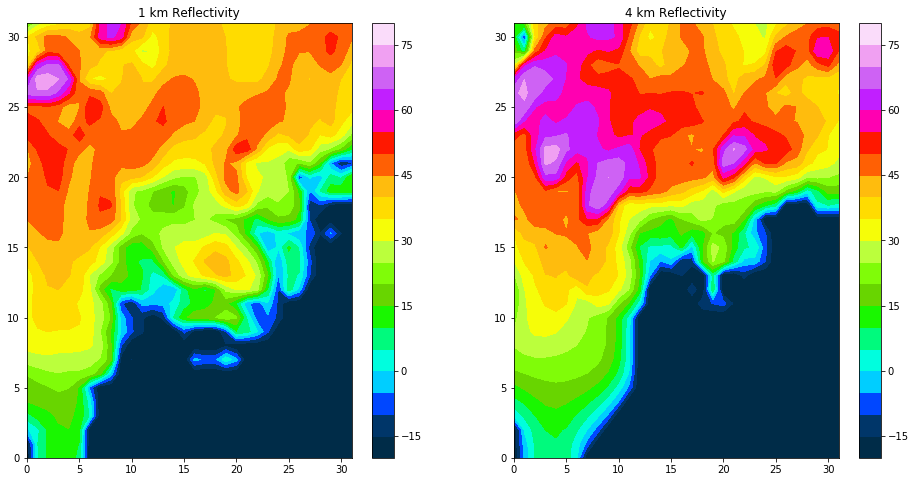

In [12]:
plot_ind = 53431
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.contourf(storm_data[plot_ind, :, :, 0], np.arange(-20, 85, 5), cmap="gist_ncar", vmin=-20, vmax=80)
plt.title("1 km Reflectivity")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.contourf(storm_data[plot_ind, :, :, 1], np.arange(-20, 85, 5), cmap="gist_ncar", vmin=-20, vmax=80)
plt.title("4 km Reflectivity")
plt.colorbar()

In [94]:
s_range

102.2

In [15]:
s_min = storm_data[:, :, :, 1].min()
s_max = storm_data[:, :, :, 1].max()
s_range = s_max - s_min
norm_data = (storm_data[:, :, :, 1:2] - s_min) / s_range
print(norm_data.shape, norm_data.max(), norm_data.min())

(114229, 32, 32, 1) 1.0 0.0


In [161]:
def hail_conv_net(data_width=32, num_input_channels=1, filter_width=5, min_conv_filters=16,
                  filter_growth_rate=2, min_data_width=4,
                  dropout_alpha=0, activation="relu", regularization_alpha=0.01, optimizer="sgd",
                  learning_rate=0.001, loss="mse", metrics=("mae", "auc"), **kwargs):
    device = "/gpu:0"
    with K.tf.device(device):
        cnn_input = Input(shape=(data_width, data_width, num_input_channels))
        num_conv_layers = int(np.log2(data_width) - np.log2(min_data_width))
        num_filters = min_conv_filters
        cnn_model = cnn_input
        for c in range(num_conv_layers):
            cnn_model = Conv2D(num_filters, (filter_width, filter_width), strides=1, padding="same",
                               kernel_regularizer=l2(regularization_alpha))(cnn_model)
            if activation == "leaky":
                cnn_model = LeakyReLU(0.1)(cnn_model)
            else:
                cnn_model = Activation(activation)(cnn_model)
            cnn_model = AveragePooling2D(padding="same")(cnn_model)
            num_filters = int(num_filters * filter_growth_rate)
        cnn_model = Flatten()(cnn_model)
        cnn_model = Dense(1, kernel_regularizer=l2(regularization_alpha))(cnn_model)
        cnn_model = Activation("sigmoid")(cnn_model)
        cnn_model_complete = Model(cnn_input, cnn_model)
    if optimizer.lower() == "sgd":
        opt = SGD(lr=learning_rate, decay=1e-6, momentum=0.99, nesterov=True)
    else:
        opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.99)
    cnn_model_complete.compile(optimizer=opt, loss=loss, metrics=metrics)
    return cnn_model_complete

In [142]:
seed = 53432
np.random.seed(seed)
train_split = 22
run_dates = storm_meta["run_dates"].unique()
perm_run_dates = np.random.permutation(run_dates)
train_dates = np.sort(perm_run_dates[:train_split])
test_dates = np.sort(perm_run_dates[train_split:])
print(train_dates)
print(test_dates)
train_i = np.where(np.in1d(storm_meta["run_dates"].values, train_dates))[0]
test_i = np.where(np.in1d(storm_meta["run_dates"].values, test_dates))[0]
print(train_i)
print(test_i)

[2016050300 2016050400 2016050600 2016050700 2016050800 2016050900
 2016051100 2016051200 2016051300 2016051500 2016051800 2016051900
 2016052000 2016052200 2016052300 2016052400 2016052600 2016052700
 2016052800 2016060100 2016060200 2016060300]
[2016050500 2016051000 2016051400 2016051600 2016051700 2016052100
 2016052500 2016052900 2016053000 2016053100]
[     0      1      2 ..., 114226 114227 114228]
[  2303   2304   2305 ..., 103217 103218 103219]


In [199]:
session = K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=False,
                                                    gpu_options=K.tf.GPUOptions(allow_growth=True),
                                                    log_device_placement=False))
K.set_session(session)
hail_cnn = hail_conv_net(num_input_channels=1, min_data_width=4, dropout_alpha=0.2, 
                         min_conv_filters=8, filter_width=5, filter_growth_rate=2, activation="selu",
                         regularization_alpha=0.001, metrics=[], optimizer="adam")
out_log = hail_cnn.fit(norm_data[train_i], hail_labels[train_i], epochs=30, validation_split=0.2, batch_size=512)

Train on 62660 samples, validate on 15666 samples
Epoch 1/30
62660/62660 [==============================] - 11s 168us/step - loss: 0.1716 - val_loss: 0.1123
Epoch 2/30
62660/62660 [==============================] - 4s 68us/step - loss: 0.1498 - val_loss: 0.1035
Epoch 3/30
62660/62660 [==============================] - 4s 68us/step - loss: 0.1439 - val_loss: 0.1057
Epoch 4/30
62660/62660 [==============================] - 4s 68us/step - loss: 0.1411 - val_loss: 0.1051
Epoch 5/30
62660/62660 [==============================] - 4s 68us/step - loss: 0.1395 - val_loss: 0.0974
Epoch 6/30
62660/62660 [==============================] - 4s 68us/step - loss: 0.1391 - val_loss: 0.1034
Epoch 7/30
62660/62660 [==============================] - 4s 68us/step - loss: 0.1374 - val_loss: 0.0952
Epoch 8/30
62660/62660 [==============================] - 4s 68us/step - loss: 0.1368 - val_loss: 0.0984
Epoch 9/30
62660/62660 [==============================] - 4s 68us/step - loss: 0.1359 - val_loss: 0.0987
Epo

In [13]:
hail_cnn_random = hail_conv_net(num_input_channels=1, min_data_width=4, dropout_alpha=0.2, 
                         min_conv_filters=8, filter_width=5, filter_growth_rate=2, 
                         regularization_alpha=0.001, metrics=[])
out_log = hail_cnn_random.fit(norm_data[train_i], np.random.permutation(hail_labels[train_i]), epochs=10, validation_split=0, )

Epoch 1/10
78326/78326 [==============================] - 18s 230us/step - loss: 0.1613
Epoch 2/10
78326/78326 [==============================] - 12s 157us/step - loss: 0.1427
Epoch 3/10
78326/78326 [==============================] - 12s 156us/step - loss: 0.1375
Epoch 4/10
78326/78326 [==============================] - 12s 156us/step - loss: 0.1356
Epoch 5/10
78326/78326 [==============================] - 12s 157us/step - loss: 0.1349
Epoch 6/10
78326/78326 [==============================] - 12s 157us/step - loss: 0.1346
Epoch 7/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1345
Epoch 8/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1345
Epoch 9/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1345
Epoch 10/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1345


In [14]:
cnn_random_preds = hail_cnn_random.predict(norm_data[test_i])[:, 0]
print(brier_skill_score(hail_labels[test_i], cnn_random_preds))
print(roc_auc(hail_labels[test_i], cnn_random_preds))

-0.0148799238515
-0.0


In [139]:
sess_old = K.get_session()
sess_old.close()

In [200]:
cnn_preds = hail_cnn.predict(norm_data[test_i])[:, 0]
print(brier_skill_score(hail_labels[test_i], cnn_preds))
print(roc_auc(hail_labels[test_i], cnn_preds))

0.132023153678
0.716186836335


(array([  8.96500000e+03,   1.55130000e+04,   5.65300000e+03,
          2.63500000e+03,   1.47100000e+03,   8.37000000e+02,
          5.06000000e+02,   2.45000000e+02,   7.60000000e+01,
          2.00000000e+00]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

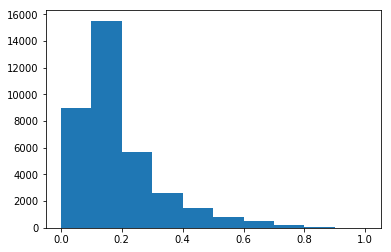

In [164]:
plt.hist(cnn_preds, np.arange(0, 1.1, 0.1))

In [24]:
out_path = "/scratch/dgagne/radar_hail_results_20180307/"


In [228]:
save_model(hail_cnn, join(out_path, "radar_cnn.h5"))

In [201]:
def visualize_layer(cnn_model, out_prob, max_iter=5, min_loss=0.001, step=0.1, dropout=False):
    layer_out = cnn_model.output
    input_image = cnn_model.input
    loss = 0.5 * (K.constant(out_prob) - layer_out) ** 2
    grads = K.gradients(loss, input_image)[0]
    #grads -= K.min(grads)
    #grads /= K.maximum(K.max(grads) - K.min(grads), K.epsilon())
    #grads /= K.maximum(K.mean(grads), K.epsilon())
    #grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_image, K.learning_phase()], 
                         [loss, grads])
    
    input_img_data = np.zeros(shape=(1, 32, 32, 1))
    #input_img_data = np.random.random(size=(1, 32, 32, 1)) * 0.01
    #input_img_data = np.random.normal(size=(1, 32, 32, 15)) * 0.1
    loss_val = 2
    num_iter = 0
    while num_iter < max_iter and loss_val > 0.01:
        loss_value, grads_value = iterate([input_img_data, dropout])
        loss_val = loss_value[0, 0]
        print(loss_value, np.abs(grads_value).max(), grads_value.mean(), grads_value.std())
        input_img_data -= grads_value * step
        input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())
        #input_img_data[input_img_data > 1] = 1
        #input_img_data[input_img_data < -1] = -1
        num_iter += 1
    return input_img_data

In [202]:
out_storm = visualize_layer(hail_cnn, 1, max_iter=50, min_loss=0.001, step=0.1, dropout=False)
out_storm.max(), out_storm.min()

[[ 0.39975274]] 0.00265201 -4.05569e-05 0.000835648
[[ 0.0856531]] 0.0134613 -0.000612661 0.00348717
[[ 0.08532824]] 0.0134292 -0.000608123 0.00348002
[[ 0.08500569]] 0.0133969 -0.000609028 0.00347049
[[ 0.08468448]] 0.0133653 -0.000604969 0.00346276
[[ 0.08436487]] 0.0133334 -0.000602884 0.00345501
[[ 0.08404674]] 0.0133016 -0.000600494 0.00344739
[[ 0.08373011]] 0.0132698 -0.000597936 0.00343984
[[ 0.08341502]] 0.0132381 -0.000595696 0.00343218
[[ 0.08310121]] 0.0132139 -0.00059412 0.00342718
[[ 0.08278814]] 0.0131822 -0.000591694 0.00341957
[[ 0.08247658]] 0.0131506 -0.000589432 0.00341199
[[ 0.08216643]] 0.013119 -0.000586782 0.00340457
[[ 0.08185767]] 0.0130876 -0.000584409 0.00339712
[[ 0.08154776]] 0.0130556 -0.000576997 0.00339044
[[ 0.0812389]] 0.013024 -0.000575161 0.00338276
[[ 0.08093159]] 0.0129872 -0.000570532 0.00336972
[[ 0.08062397]] 0.0129555 -0.000568418 0.00336201
[[ 0.080318]] 0.0129238 -0.000566362 0.00335436
[[ 0.08001351]] 0.0128923 -0.000564217 0.00334677
[[ 0.

(1.0, 0.0)

In [159]:
out_storm.max()

-2.5549356092386799

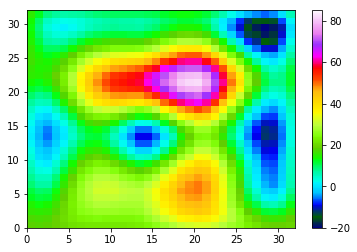

In [203]:
rescaled_storm = (out_storm - out_storm.min()) / (out_storm.max() - out_storm.min())
plt.pcolormesh((rescaled_storm[0, :, :, 0]) * s_range + s_min, vmin=-20, vmax=85,
              cmap="gist_ncar")
plt.colorbar()

In [23]:
out_storm.max(), out_storm.min()

(5.1667475202201398, -2.5660035099571239)

In [175]:
rescaled_storm.min()

-1.0

(array([  1.,   0.,   4.,   0.,   1.,   1.,   1.,   2.,   2.,   4.,   2.,
          3.,   3.,   1.,   7.,   3.,   8.,   6.,   4.,   5.,   6.,   2.,
          3.,   5.,  10.,  10.,  11.,   9.,  14.,   7.,  10.,   6.,  10.,
          8.,   4.,  12.,  11.,   7.,  10.,  12.,   9.,  14.,  13.,  14.,
          7.,   9.,   8.,   7.,  10.,  12.,   7.,  13.,   9.,   8.,   6.,
          2.,   6.,   5.,   5.,  11.,   7.,   9.,   6.,   9.,   8.,   6.,
          7.,   9.,   6.,   7.,   5.,   3.,   3.,   3.,   1.,   1.,   1.,
          2.,   3.,   0.,   2.,   0.,   1.,   1.,   1.,   1.,   0.,   1.,
          1.,   1.,   2.,   1.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.]),
 array([-0.09652013, -0.09439374, -0.09226734, -0.09014094, -0.08801454,
        -0.08588815, -0.08376175, -0.08163535, -0.07950895, -0.07738256,
        -0.07525616, -0.07312976, -0.07100336, -0.06887696, -0.06675057,
        -0.06462417, -0.06249777, -0.06037137, -0.05824498, -0.05611858,
        -0.05399218, -0.05

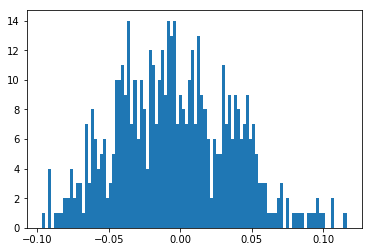

In [28]:
plt.hist(hail_cnn.layers[-2].get_weights()[0].ravel(), bins=100)

In [44]:
np.count_nonzero(np.abs(hail_cnn.layers[-2].get_weights()[0]) < 1e-3)

169

In [138]:
weights = hail_cnn.layers[-2].get_weights()[0].ravel()
num_top = 36
num_ex = 9
top_neurons = weights.argsort()[::-1][0:num_top]
top_examples = np.zeros((num_top, num_ex), dtype=int)
top_gradients = np.zeros((num_top, num_ex, 32, 32, 1))

for n, neuron in enumerate(top_neurons):
    print(n, neuron, weights[neuron])
    act_func = K.function([hail_cnn.input, K.learning_phase()], [hail_cnn.layers[-3].output[:, neuron]])
    loss = 0.5 * (hail_cnn.layers[-3].output[:, neuron] - 4) ** 2
    grads = K.gradients(loss, hail_cnn.input)[0]
    grads /= K.maximum(K.std(grads), K.epsilon())
    #grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
    grad_func = K.function([hail_cnn.input, K.learning_phase()], [grads])
    act_values = act_func([norm_data, 0])[0]
    top_examples[n] = act_values.argsort()[::-1][0:num_ex]
    top_gradients[n] = -grad_func([norm_data[top_examples[n]],0])[0]

0 172 0.135926


ResourceExhaustedError: OOM when allocating tensor with shape[114229,8,32,32]
	 [[Node: batch_normalization_4/FusedBatchNorm = FusedBatchNorm[T=DT_FLOAT, data_format="NHWC", epsilon=0.001, is_training=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_22/BiasAdd, batch_normalization_4/gamma/read, batch_normalization_4/beta/read, batch_normalization_4/Const_4, batch_normalization_4/Const_4)]]
	 [[Node: strided_slice_428/_249 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_182_strided_slice_428", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'batch_normalization_4/FusedBatchNorm', defined at:
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-133-191926c60d2c>", line 7, in <module>
    regularization_alpha=0.001, metrics=[], optimizer="adam")
  File "<ipython-input-132-169d48656d63>", line 14, in hail_conv_net
    cnn_model = BatchNormalization()(cnn_model)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/Keras-2.1.2-py3.6.egg/keras/engine/topology.py", line 605, in __call__
    output = self.call(inputs, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/Keras-2.1.2-py3.6.egg/keras/layers/normalization.py", line 177, in call
    epsilon=self.epsilon)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/Keras-2.1.2-py3.6.egg/keras/backend/tensorflow_backend.py", line 1817, in normalize_batch_in_training
    epsilon=epsilon)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/Keras-2.1.2-py3.6.egg/keras/backend/tensorflow_backend.py", line 1792, in _fused_normalize_batch_in_training
    data_format=tf_data_format)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py", line 831, in fused_batch_norm
    name=name)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 2034, in _fused_batch_norm
    is_training=is_training, name=name)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[114229,8,32,32]
	 [[Node: batch_normalization_4/FusedBatchNorm = FusedBatchNorm[T=DT_FLOAT, data_format="NHWC", epsilon=0.001, is_training=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_22/BiasAdd, batch_normalization_4/gamma/read, batch_normalization_4/beta/read, batch_normalization_4/Const_4, batch_normalization_4/Const_4)]]
	 [[Node: strided_slice_428/_249 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_182_strided_slice_428", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [204]:
top_neuron_opts = np.zeros((num_top, 1, 32, 32, 1))
for n, neuron in enumerate(top_neurons):
    print(n, neuron, weights[neuron])
    loss = 0.5 * (hail_cnn.layers[-3].output[:, neuron] - 4) ** 2
    grads = K.gradients(loss, hail_cnn.input)[0]
    grads /= K.maximum(K.std(grads), K.epsilon())
    #grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
    grad_func = K.function([hail_cnn.input, K.learning_phase()], [grads])
    for i in range(10):
        grad_val = grad_func([top_neuron_opts[n], 0])[0]
        print(grad_val.max())
        top_neuron_opts[n] -= 0.01 * grad_val

0 172 0.135926
2.93567
2.25663
1.8449
1.71087
1.61126
1.54748
1.51381
1.53309
1.54966
1.56384
1 294 0.134929
2.03602
1.22497
1.16107
1.10652
1.0828
1.08762
1.13376
1.18253
1.22093
1.19615
2 183 0.132001
3.60789
3.49684
3.28518
3.10814
2.97976
2.86898
2.74319
2.62132
2.5752
2.5331
3 166 0.131874
2.04978
1.23855
1.14973
1.08435
1.04287
1.0347
1.06163
1.09932
1.12967
1.12342
4 445 0.10931
3.28681
2.92727
2.62863
2.65547
2.5368
2.46931
2.46826
2.46496
2.45934
2.41051
5 344 0.103725
1.28599
0.920126
0.883961
0.870795
0.792864
0.663021
0.596559
0.276418
0.224581
0.241581
6 408 0.10197
1.2162
0.948548
0.953797
0.882854
0.789328
0.755289
0.736991
0.727176
0.75666
0.777481
7 315 0.100554
3.27509
3.80516
3.30713
3.1708
2.92577
2.88393
2.74766
2.62735
2.52772
2.44098
8 341 0.100013
1.85521
1.03173
0.962112
0.933562
0.953121
0.982018
1.03273
1.11477
1.1732
1.23156
9 179 0.0976132
2.87139
3.19401
2.87384
3.24949
3.24561
3.15802
3.08292
3.16025
3.09292
3.02545
10 292 0.0933201
1.09984
0.630327
0.619

In [72]:
bot_neurons = weights.argsort()[0:num_top]
bot_examples = np.zeros((num_top, num_ex), dtype=int)
bot_gradients = np.zeros((num_top, num_ex, 32, 32, 1))
for n, neuron in enumerate(bot_neurons):
    print(n, neuron, weights[neuron])
    act_func = K.function([hail_cnn.input, K.learning_phase()], [hail_cnn.layers[-3].output[:, neuron]])
    loss = 0.5 * (hail_cnn.layers[-3].output[:, neuron] - 4) ** 2
    grads = K.gradients(loss, hail_cnn.input)[0]
    grads /= K.maximum(K.std(grads), K.epsilon())
    #grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
    grad_func = K.function([hail_cnn.input, K.learning_phase()], [grads])
    act_values = act_func([norm_data, 0])[0]
    bot_examples[n] = act_values.argsort()[::-1][0:num_ex]
    bot_gradients[n] = -grad_func([norm_data[bot_examples[n]],0])[0]

0 174 -0.148571
1 199 -0.123078
2 455 -0.120621
3 238 -0.11695
4 231 -0.116439
5 46 -0.112755
6 167 -0.108067
7 61 -0.104306
8 221 -0.102265
9 381 -0.102209
10 302 -0.101489
11 253 -0.100315
12 206 -0.098488
13 14 -0.0973105
14 366 -0.096823
15 483 -0.090976
16 451 -0.0848969
17 359 -0.0816328
18 7 -0.0814246
19 34 -0.0811589
20 142 -0.0802604
21 162 -0.0791466
22 125 -0.0788903
23 487 -0.0766371
24 334 -0.0756742
25 29 -0.0746451
26 419 -0.0728217
27 208 -0.0691021
28 322 -0.0656118
29 110 -0.0652021
30 93 -0.0650465
31 39 -0.0645897
32 203 -0.0612349
33 103 -0.0604262
34 423 -0.0601188
35 2 -0.0598892


In [79]:
all_act_func = K.function([hail_cnn.input, K.learning_phase()], [hail_cnn.layers[-3].output[:]])
out_acts = all_act_func([norm_data[test_i],0])[0]
aucs = np.zeros(weights.shape)
for a in range(aucs.size):
    if weights[a] >= 0:
        aucs[a] = roc_auc(hail_labels[test_i], out_acts[:, a])
    else:
        aucs[a] = roc_auc(hail_labels[test_i], out_acts[:, a].max() -out_acts[:, a])

(array([  1.30000000e+01,   4.20000000e+01,   1.46000000e+02,
          3.66000000e+02,   1.16500000e+03,   1.82300000e+03,
          3.91200000e+03,   1.86110000e+04,   7.95200000e+03,
          1.87300000e+03]),
 array([ 0.16015625,  0.17285156,  0.18554688,  0.19824219,  0.2109375 ,
         0.22363281,  0.23632812,  0.24902344,  0.26171875,  0.27441406,
         0.28710938]),
 <a list of 10 Patch objects>)

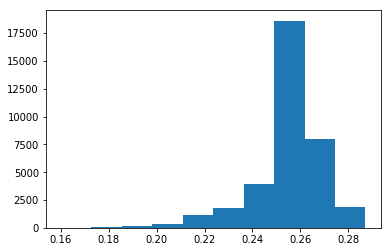

In [105]:
plt.hist(np.where((weights < 0) & (out_acts > 0), 1, 0).sum(axis=1) / 512)

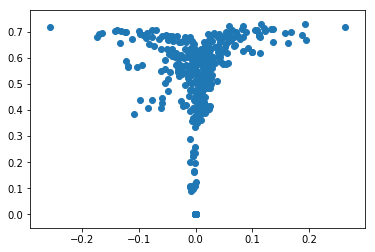

In [82]:
plt.scatter(weights, aucs)


In [392]:
np.count_nonzero(weights > 0)

262

In [386]:
for neur in range(num_top):
    print(neur)
    fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
    plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
    cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
    axef = axes.ravel()
    for a, ax in enumerate(axef):
        cont = ax.contourf(storm_data[top_examples[neur, a], :, :, 2], 
                           np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
        ax.set_facecolor('0.6')
        v_min = top_gradients[neur, a, :, :, 0].min()
        v_max = top_gradients[neur, a, :, :, 0].max()
        scale_max = np.maximum(-v_min, v_max)
        ax.contour(top_gradients[neur, a, :, :, 0], [v_min /2, v_min / 4, v_max /4, v_max / 2], 
                   vmin=-scale_max, vmax=scale_max, cmap="RdBu", linewidths=3)
        ax.set_xticks(np.arange(8, 32, 8))
        ax.set_xticklabels(np.arange(8, 32, 8) * 3, fontsize=14)
        ax.set_yticks(np.arange(8, 32, 8))
        ax.set_yticklabels(np.arange(8, 32, 8) * 3, fontsize=14)
        ax.text(1, 2, storm_meta.loc[top_examples[neur, a], "valid_dates"].strftime("%y-%m-%d H%H"))
        ax.text(16, 2, "Hail Size: {0:02.0f} mm".format(max_hail[top_examples[neur, a]]))
    axes[2, 1].set_xlabel("X Distance (km)", fontsize=14)
    axes[1, 0].set_ylabel("Y Distance (km)", fontsize=14)
    cbar = fig.colorbar(cont, cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel("4 km Height Radar Reflectivity (dBZ)", fontsize=14)
    fig.suptitle("Top Activated Examples and Interest Regions for Neuron {0:d} Rank {1:d}".format(top_neurons[neur], neur + 1), fontsize=14)
    plt.savefig(join(out_path, "radar_cnn_top_act_neuron_{0:03d}.png".format(neur + 1)), dpi=200, bbox_inches="tight")
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [93]:
neur = 0
for neur in range(num_top):
    print(neur)
    fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
    plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
    cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
    axef = axes.ravel()
    for a, ax in enumerate(axef):
        rad_img = storm_data[top_examples[neur, a], :, :, 1]
        cont = ax.pcolormesh(np.ma.array(rad_img, mask=rad_img < -10), cmap="gist_ncar", vmin=-10, vmax=80)
        #cont = ax.contourf(storm_data[top_examples[neur, a], :, :, 2], 
        #                   np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
        ax.set_facecolor('0.6')
        v_min = top_gradients[neur, a, :, :, 0].min()
        v_max = top_gradients[neur, a, :, :, 0].max()
        scale_max = np.maximum(-v_min, v_max)
        print(v_min, v_max)
        ax.contour(top_gradients[neur, a, :, :, 0], [v_min /2, v_min / 4, v_max /4, v_max / 2], 
                   vmin=-scale_max, vmax=scale_max, cmap="RdBu", linewidths=3)
        ax.set_xticks(np.arange(8, 32, 8))
        ax.set_xticklabels(np.arange(8, 32, 8) * 3, fontsize=14)
        ax.set_yticks(np.arange(8, 32, 8))
        ax.set_yticklabels(np.arange(8, 32, 8) * 3, fontsize=14)
        ax.text(1, 2, storm_meta.loc[top_examples[neur, a], "valid_dates"].strftime("%y-%m-%d H%H"))
        ax.text(16, 2, "Hail Size: {0:02.0f} mm".format(max_hail[top_examples[neur, a]]))
    axes[2, 1].set_xlabel("X Distance (km)", fontsize=14)
    axes[1, 0].set_ylabel("Y Distance (km)", fontsize=14)
    cbar = fig.colorbar(cont, cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel("4 km Height Radar Reflectivity (dBZ)", fontsize=14)
    fig.suptitle("Top Activated Examples and Interest Regions for Neuron {0:d} Rank {1:d}".format(top_neurons[neur], neur + 1), fontsize=14)
    plt.savefig(join(out_path, "radar_cnn_top_act_neuron_pc_{0:03d}.png".format(neur + 1)), dpi=200, bbox_inches="tight")
    plt.close()

0
-0.376254141331 3.95466899872
-0.608960986137 4.60965013504
-0.714523077011 4.77930641174
-0.581401050091 5.0763297081
-0.562852442265 5.03040504456
-0.919314980507 5.11363554001
-0.520773172379 5.41542243958
-0.675500810146 5.39569473267
-0.717120110989 5.27491521835
1
-0.71620965004 4.27630376816
-0.558136641979 4.38692045212
-0.937213182449 4.10096359253
-0.810148179531 4.50972270966
-1.00324106216 5.1278553009
-0.682376027107 5.08993387222
-0.636691451073 5.06129312515
-1.01847207546 5.45205593109
-0.590832293034 4.48524284363
2
-0.83968681097 4.21030664444
-0.626460671425 4.25699567795
-0.44232904911 4.07771348953
-0.708987951279 4.54796600342
-0.954959154129 4.2164311409
-0.6844176054 4.71858119965
-0.806157529354 4.50193452835
-0.630039334297 4.61472034454
-0.769271016121 4.51064920425
3
-0.687372803688 4.29364538193
-0.645084381104 4.25768756866
-0.687220990658 4.22406339645
-0.659547269344 5.1389093399
-0.739475607872 5.18580436707
-0.887737512589 5.10771560669
-0.7216779589

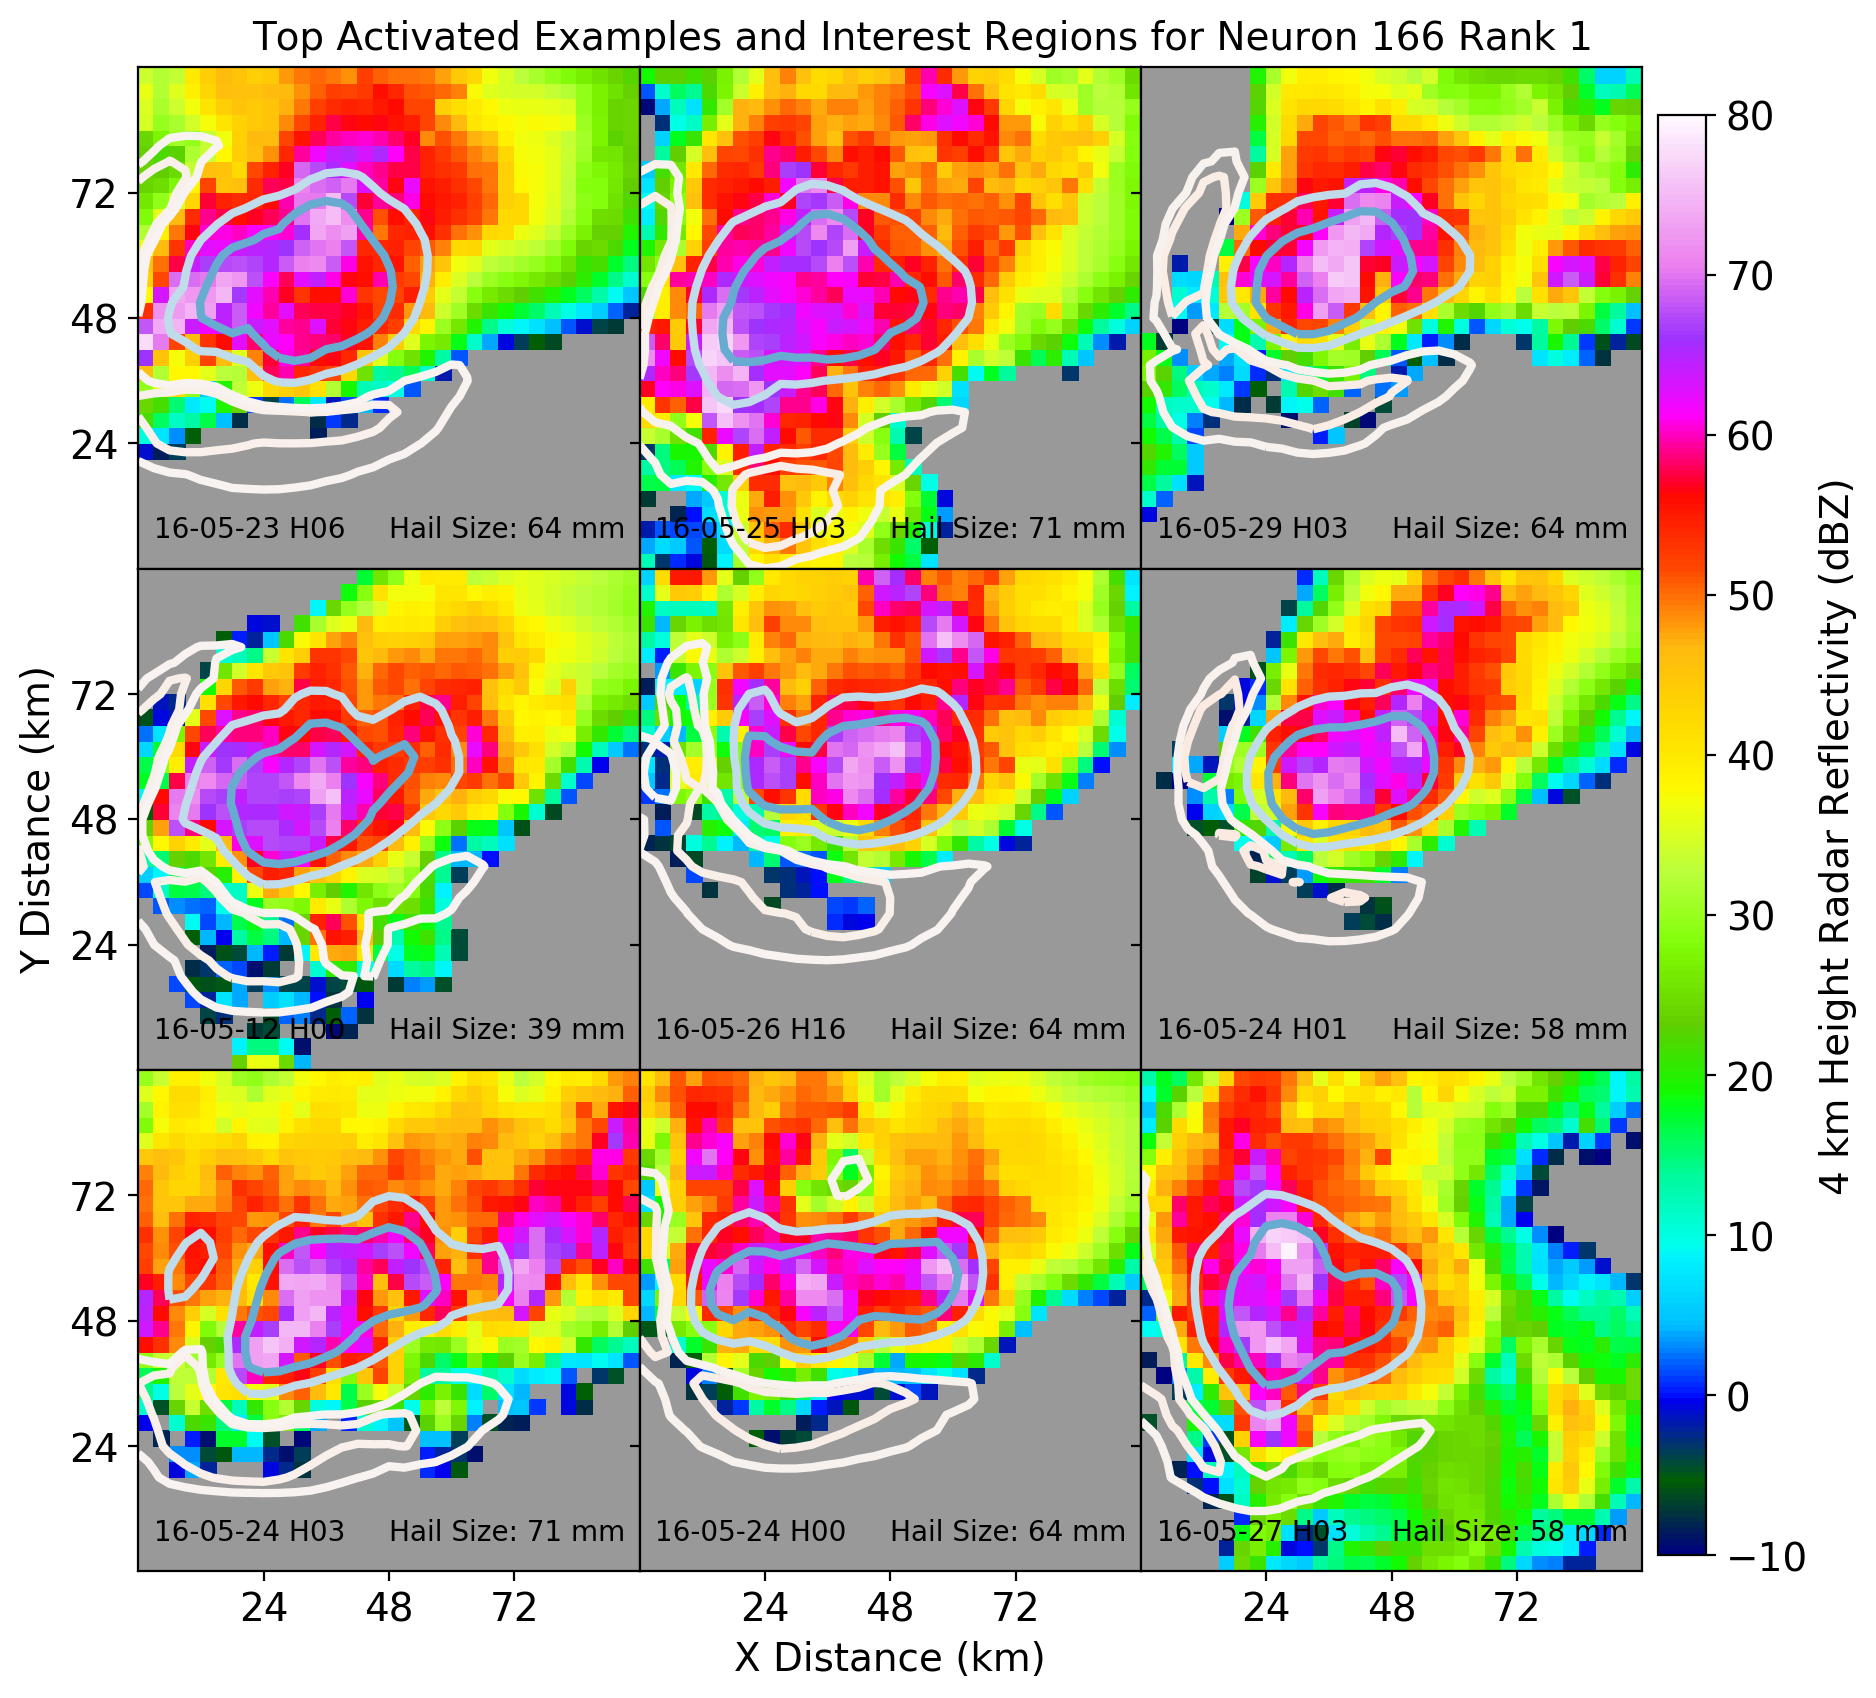

In [99]:


img_files = sorted(glob(join(out_path, "radar_cnn_top_act_neuron_pc_*.png")))
Image(img_files[0])

In [362]:
storm_meta.loc[5, "valid_dates"].strftime("%Y-%m-%d %H")

'2016-05-03 13'

In [74]:
mean_grads = top_gradients.max(axis=1)[:, :, :, 0]
bot_mean_grads = bot_gradients.mean(axis=1)[:, :, :, 0]

In [26]:
mean_grads.min()

-4.0984136263529463

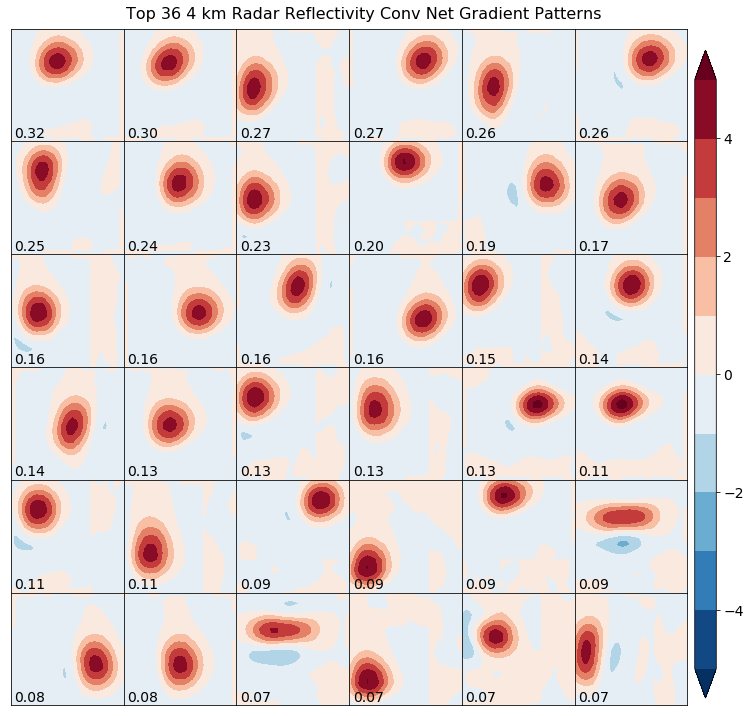

In [70]:
mean_grads = top_gradients.mean(axis=1)[:, :, :, 0]

fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
axef = axes.ravel()
for a, ax in enumerate(axef):
    cont = ax.contourf(mean_grads[a], np.arange(-5, 6), extend="both", cmap="RdBu_r")
    ax.text(1, 1, "{0:0.2f}".format(weights[top_neurons[a]]), fontsize=14)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Top 36 4 km Radar Reflectivity Conv Net Gradient Patterns", fontsize=16)
plt.savefig(join(out_path, "top_36_radar_cnn_grads.png"), dpi=200, bbox_inches="tight")

0.262410661206 -0.386792466044
0.279108991846 -0.386792466044
0.201149607077 -0.386792466044
0.273883894086 -0.386792466044
0.364550705999 -0.386792466044
0.385850455612 -0.386792466044
0.407740231603 -0.386792466044
0.245264437981 -0.386792466044
0.291187515482 -0.386792466044
0.326230226085 -0.386792466044
0.306470718235 -0.386792466044
0.307692265138 -0.386792466044
0.272403929383 -0.386792466044
0.294222621247 -0.386792466044
0.217640533112 -0.386792466044
0.364507231861 -0.386792466044
0.312235189602 -0.386792466044
0.392754945904 -0.386792466044
0.337347021326 -0.386792466044
0.360899766907 -0.386792466044
0.229827434756 -0.386792466044
0.392520729452 -0.386792466044
0.199609071948 -0.386792466044
0.275752840564 -0.386792466044
0.309473471716 -0.386792466044
0.318866601214 -0.386792466044
0.193565886468 -0.386792466044
0.355267951265 -0.386792466044
0.342565402389 -0.386792466044
0.34228942357 -0.386792466044
0.306770499796 -0.386792466044
0.290089478716 -0.386792466044
0.3865017

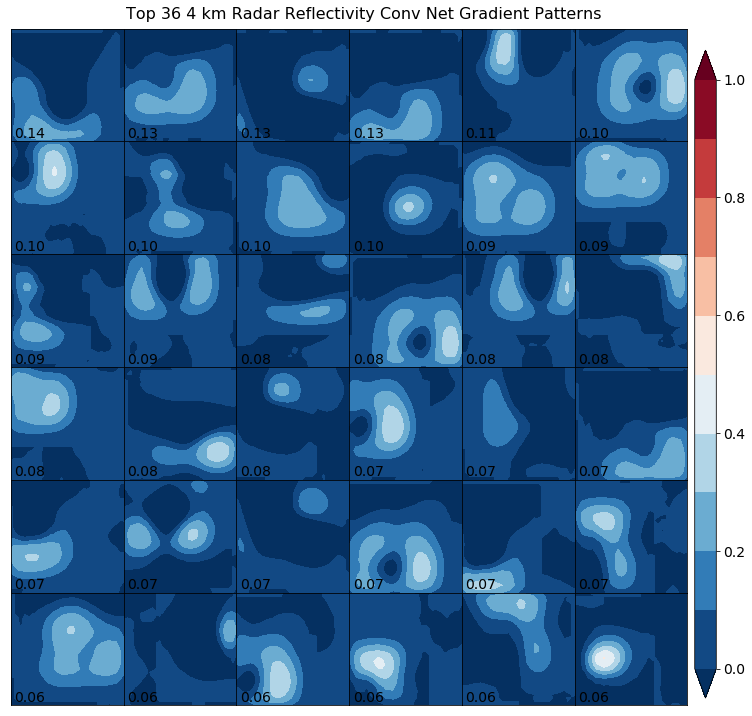

In [205]:
fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
axef = axes.ravel()
for a, ax in enumerate(axef):
    print(top_neuron_opts[a, 0, :, :, 0].max() ,top_neuron_opts.min())
    cont = ax.contourf(top_neuron_opts[a, 0, :, :, 0], np.arange(0, 1.1, 0.1), extend="both", cmap="RdBu_r")
    ax.text(1, 1, "{0:0.2f}".format(weights[top_neurons[a]]), fontsize=14)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Top 36 4 km Radar Reflectivity Conv Net Gradient Patterns", fontsize=16)
plt.savefig(join(out_path, "top_36_radar_cnn_neuron_opts.png"), dpi=200, bbox_inches="tight")

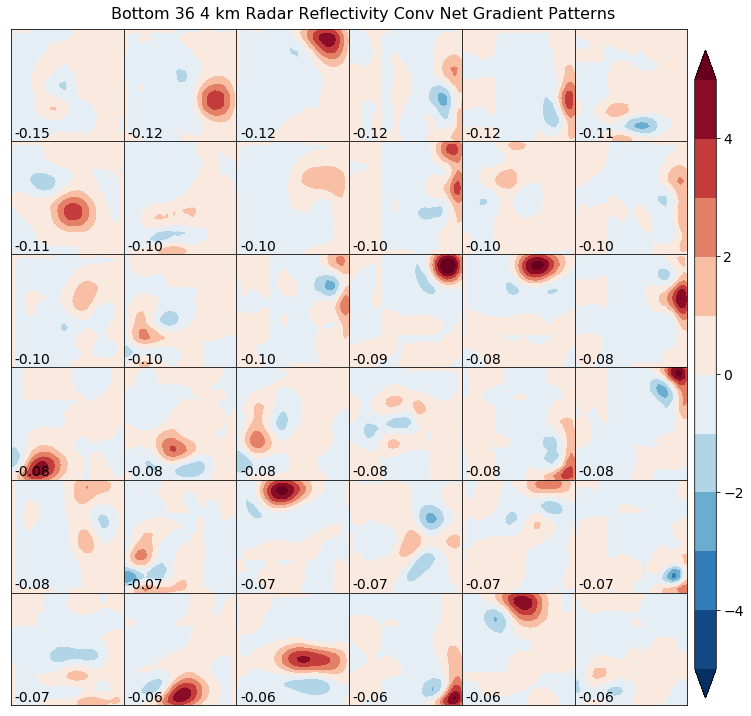

In [75]:
fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
axef = axes.ravel()
for a, ax in enumerate(axef):
    cont = ax.contourf(bot_mean_grads[a], np.arange(-5, 6), extend="both", cmap="RdBu_r")
    ax.text(1, 1, "{0:0.2f}".format(weights[bot_neurons[a]]), fontsize=14)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Bottom 36 4 km Radar Reflectivity Conv Net Gradient Patterns", fontsize=16)
plt.savefig(join(out_path, "bot_36_radar_cnn_grads.png"), dpi=200, bbox_inches="tight")

In [402]:
mean_grads.min()

-11.469572385152182

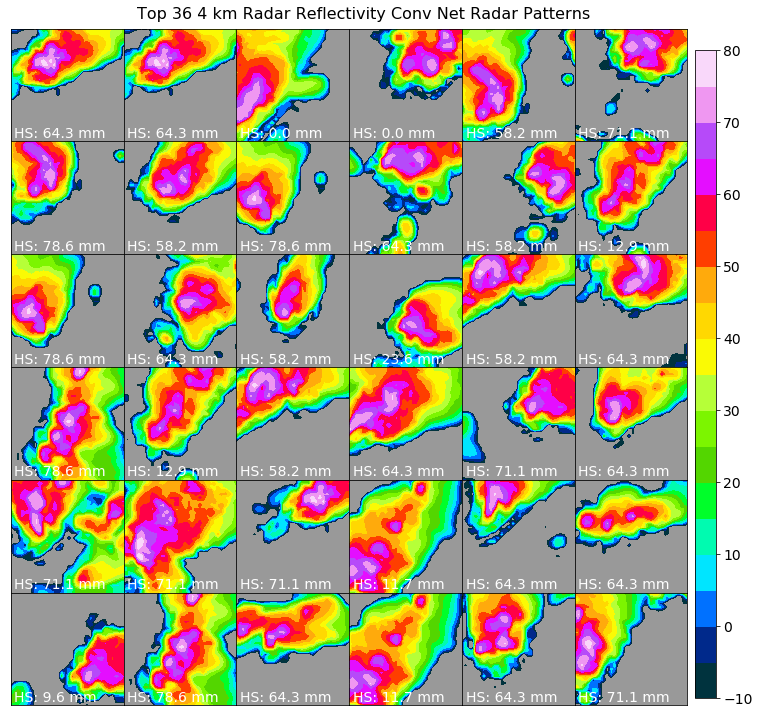

In [51]:
fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)

axef = axes.ravel()
for a, ax in enumerate(axef):
    cont = ax.contourf(storm_data[top_examples[a, 0], :, :, 1], 
                           np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
    ax.set_facecolor('0.6')
    ax.text(1, 1, "HS: {0:0.1f} mm".format(max_hail[top_examples[a, 0]]), fontsize=14, color="w")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Top 36 4 km Radar Reflectivity Conv Net Radar Patterns", fontsize=16)
plt.savefig(join(out_path, "top_36_radar_cnn_refl.png"), dpi=200, bbox_inches="tight")

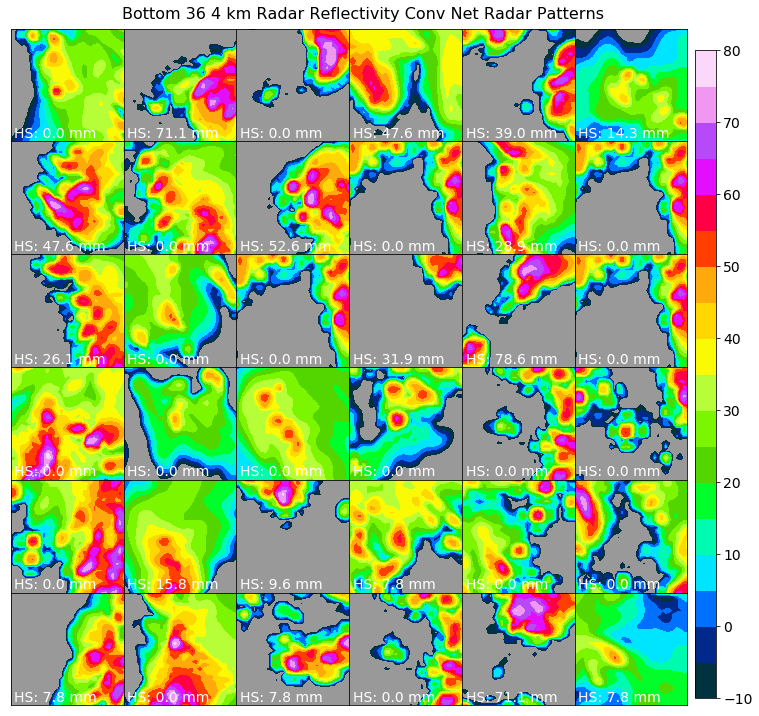

In [76]:
fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
axef = axes.ravel()
for a, ax in enumerate(axef):
    cont = ax.contourf(storm_data[bot_examples[a, 0], :, :, 1], 
                           np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
    ax.set_facecolor('0.6')
    ax.text(1, 1, "HS: {0:0.1f} mm".format(max_hail[bot_examples[a, 0]]), fontsize=14, color="w")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Bottom 36 4 km Radar Reflectivity Conv Net Radar Patterns", fontsize=16)
plt.savefig(join(out_path, "bot_36_radar_cnn_refl.png"), dpi=200, bbox_inches="tight")

In [192]:
hail_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 8)         208       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 8)         0         
_________________________________________________________________
average_pooling2d_28 (Averag (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 16)        3216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 16)        0         
_________________________________________________________________
average_pooling2d_29 (Averag (None, 8, 8, 16)          0         
__________

In [193]:
hail_net_diag = K.function([hail_cnn.input, K.learning_phase()], 
                           [hail_cnn.layers[3].output, hail_cnn.layers[6].output, hail_cnn.layers[9].output,
                           hail_cnn.output])

In [194]:
diag_out = hail_net_diag([norm_data[top_examples[0, 0:1]], 0])

In [80]:
rad_img = storm_data[top_examples[0, 0], :, :, 0]

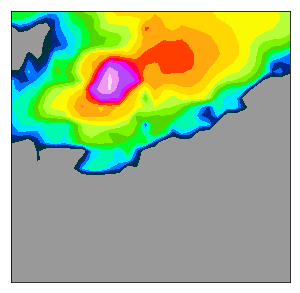

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_facecolor("0.6")
orig_ticks = np.linspace(0, 31, 32) + 0.5

#cont = ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, extend="max", cmap="Blues_r")
cont = ax.contourf(orig_ticks, orig_ticks, rad_img, 
                           np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
#ax.clabel(cont, fontsize=14, fmt="%d")
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.savefig(join(out_path, "radar_cnn_conv_input.png"), dpi=200, bbox_inches="tight")

In [208]:
print(diag_out[0].max(), diag_out[0].min())
print(diag_out[1].max(), diag_out[0].min())
print(diag_out[2].max(), diag_out[0].min())

1.67217 0.0
2.92934 0.0
2.67195 0.0


[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5
  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5]


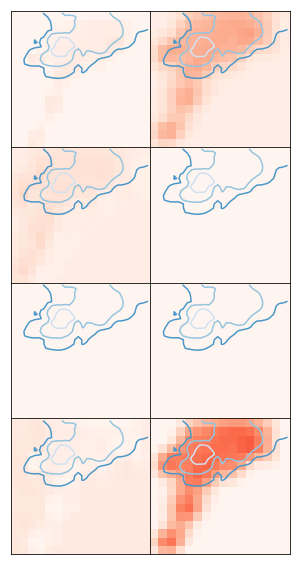

In [195]:
fig, axes = plt.subplots(4, 2, figsize=(5, 10))
plt.subplots_adjust(wspace=0, hspace=0)
ax_ticks = np.linspace(0, 32, 17)
print(orig_ticks)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    act_img = diag_out[0][0, :, :, a]
    ax.pcolormesh(ax_ticks, ax_ticks, np.ma.array(act_img, mask=act_img==0), cmap="Reds", vmin=0, vmax=3)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
plt.savefig(join(out_path, "radar_cnn_conv_act_1.png"), dpi=200, bbox_inches="tight")

[  0.   4.   8.  12.  16.  20.  24.  28.  32.]


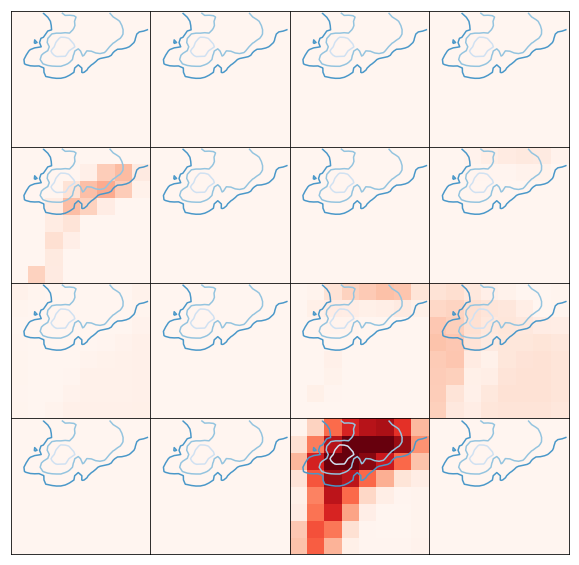

In [196]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
ax_ticks = np.linspace(0, 32, 9)
print(ax_ticks)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    act_img = diag_out[1][0, :, :, a]
    ax.pcolormesh(ax_ticks, ax_ticks, np.ma.array(act_img, mask=act_img==0), cmap="Reds", vmin=0, vmax=3)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
plt.savefig(join(out_path, "radar_cnn_conv_act_2.png"), dpi=200, bbox_inches="tight")

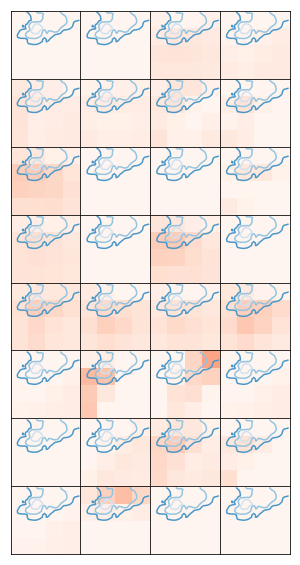

In [197]:
fig, axes = plt.subplots(8, 4, figsize=(5, 10))
plt.subplots_adjust(wspace=0, hspace=0)
ax_ticks = np.linspace(0, 32, 5)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    act_img = diag_out[2][0, :, :, a]
    ax.pcolormesh(ax_ticks, ax_ticks, np.ma.array(act_img, mask=act_img==0), cmap="Reds", vmin=0, vmax=3)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
plt.savefig(join(out_path, "radar_cnn_conv_act_3.png"), dpi=200, bbox_inches="tight")

In [130]:
weight_mag = hail_cnn.layers[-2].get_weights()[0].reshape(4, 4, 32)

In [203]:
weight_mag.max()

0.26273122

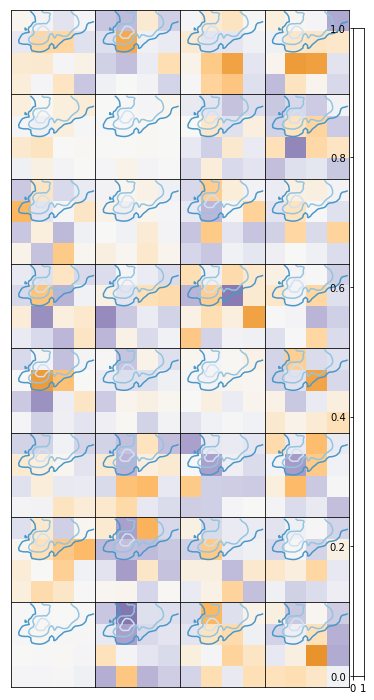

In [198]:
fig, axes = plt.subplots(8, 4, figsize=(5, 10))
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, wspace=0, hspace=0)
ax_ticks = np.linspace(0, 32, 5)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    ax.pcolormesh(ax_ticks, ax_ticks, weight_mag[:, :, a], cmap="PuOr", vmin=-0.25,vmax=0.25)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cax = fig.add_axes([0.96, 0.025, 0.03, 0.9])
#cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
plt.savefig(join(out_path, "radar_cnn_weight_mag.png"), dpi=200, bbox_inches="tight")

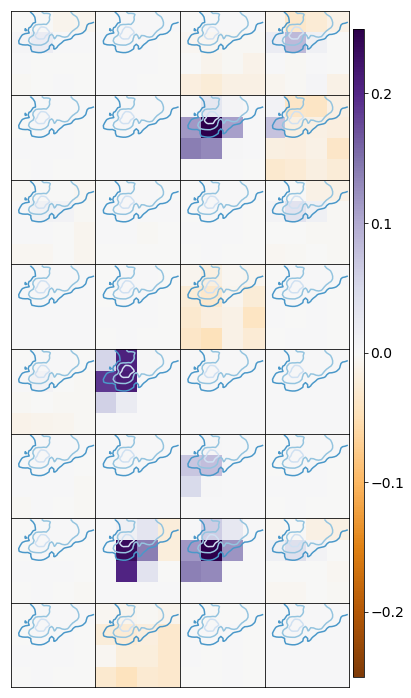

In [90]:
fig, axes = plt.subplots(8, 4, figsize=(5, 10))
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, wspace=0, hspace=0)
ax_ticks = np.linspace(0, 32, 5)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    cont = ax.pcolormesh(ax_ticks, ax_ticks, weight_mag[:, :, a] * diag_out[2][0, :, :, a], cmap="PuOr", vmin=-0.25,vmax=0.25)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cax = fig.add_axes([0.96, 0.025, 0.03, 0.9])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
plt.savefig(join(out_path, "radar_cnn_weight_out.png"), dpi=200, bbox_inches="tight")

In [215]:
diag_out[-1]

array([[ 0.98888189]], dtype=float32)